# DSE220 Final Exploratory Data Analysis Notebook

In [1]:
import gzip
from collections import defaultdict, Counter
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import pca
from sklearn.metrics import mean_absolute_error
%matplotlib inline

### read files

In [2]:
# read original files
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

orig_train_df = getDF('train.json.gz')
orig_test_df = getDF('test_Helpful.json.gz')

In [3]:
print(orig_train_df.shape, orig_test_df.shape)


(200000, 12) (14000, 12)


In [4]:
# split outOf and nHelpful out as separate columns
train_outOf = np.array([x['outOf'] for x in orig_train_df.helpful.values])
train_nHelpful = np.array([x['nHelpful'] for x in orig_train_df.helpful.values])
orig_train_df['outOf'] = train_outOf
orig_train_df['nHelpful'] = train_nHelpful
orig_train_df['pctHelpful'] = train_nHelpful / train_outOf

test_outOf = np.array([x['outOf'] for x in orig_test_df.helpful.values])
orig_test_df['outOf'] = test_outOf

/Users/joshwilson/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


In [5]:
# read preprocessed csv files
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')
test = pd.read_csv('test.csv')

### comparison of train, validation, and test sets

###### number of reviewers and reviewers in common

In [6]:
train_revIDs = set(train.reviewerID.values)
val_revIDs = set(val.reviewerID.values)
test_revIDs = set(test.reviewerID.values)

print(len(train_revIDs))
print(len(val_revIDs))
print(len(test_revIDs))
print(len(train_revIDs.intersection(val_revIDs)))
print(len(train_revIDs.intersection(test_revIDs)))

26295
10130
4059
7420
2995


###### number of items in common

In [7]:
train_itemIDs = set(train.itemID.values)
val_itemIDs = set(test.itemID.values)
test_itemIDs = set(test.itemID.values)

print(len(train_itemIDs))
print(len(val_itemIDs))
print(len(test_itemIDs))
print(len(train_itemIDs.intersection(val_itemIDs)))
print(len(train_itemIDs.intersection(test_itemIDs)))

16701
3674
3674
3264
3264


##### number of each rating

[ 0.52886461  0.20176532  0.12580894  0.07563973  0.06792139]


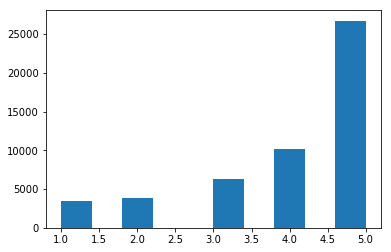

In [8]:
train_ratings = np.array(train.rating.value_counts()) / train.shape[0] * 1.0
print(train_ratings)
plt.hist(train.rating.values);

[ 0.53716162  0.19317636  0.12558065  0.07424315  0.06983822]


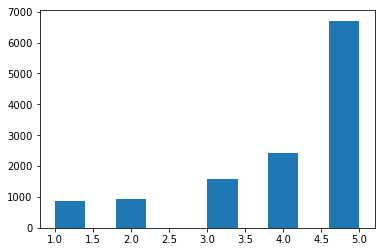

In [9]:
val_ratings = np.array(val.rating.value_counts()) / val.shape[0] * 1.0
print(val_ratings)
plt.hist(val.rating.values);

[ 0.53431818  0.19318182  0.12954545  0.07636364  0.06659091]


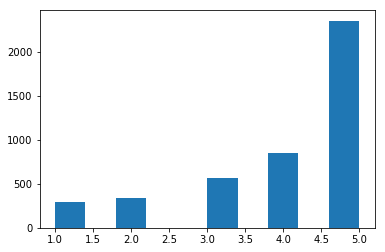

In [10]:
test_ratings = np.array(test.rating.value_counts()) / test.shape[0] * 1.0
print(test_ratings)
plt.hist(test.rating.values);

### exploratory analysis

In [11]:
train.corr().sort_values(by='pctHelpful',ascending=False).loc[:,'pctHelpful']

pctHelpful                            1.000000
avgUserHelpfulness                    0.716593
avgItemHelpfulness                    0.585750
rating                                0.178120
nHelpful                              0.140151
outOf                                 0.081301
category_Women                        0.066301
reviewTextNumSents                    0.055915
reviewTextNumWords                    0.045391
pctItemReviewsRated                   0.035348
category_Plus-Size                    0.031935
category_Petite                       0.028764
category_Gemstones                    0.028335
pctUserReviewsRated                   0.025138
category_Fine                         0.024900
category_Earrings                     0.024452
category_Slippers                     0.024431
category_Lingerie, Sleep & Lounge     0.023589
category_Amazon Curated Collection    0.023485
userRatedReviews                      0.022550
category_Knits & Tees                 0.022350
category_Slee

In [12]:
# create helper function for plotting data vs. pctHelpful
def plotVsPctHelpful(vsData):
    ttl = 'pctHelpful vs.' + vsData
    xData = train.loc[:,vsData].values
    plt.scatter(xData, train.pctHelpful, alpha=0.2)
    plt.title(ttl)
    plt.xlabel(vsData)
    plt.ylabel('pctHelpful')
    plt.show();

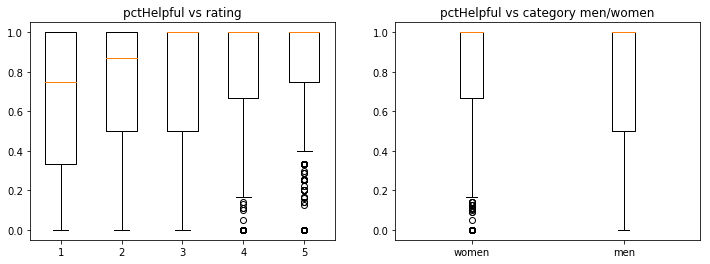

In [47]:
f, ax = plt.subplots(1,2)

data = [train.loc[train.category_Women == 1,'pctHelpful'],
       train.loc[train.category_Men == 1,'pctHelpful']]

ax[1].boxplot(data)
ax[1].set_title('pctHelpful vs category men/women')
labs = ['women','men']
ax[1].set_xticklabels(labs)

data = [train.loc[train.rating == 1,'pctHelpful'],
       train.loc[train.rating == 2,'pctHelpful'],
       train.loc[train.rating == 3,'pctHelpful'],
       train.loc[train.rating == 4,'pctHelpful'],
       train.loc[train.rating == 5,'pctHelpful']]

ax[0].boxplot(data)
ax[0].set_title('pctHelpful vs rating')
labs = [1,2,3,4,5]
ax[0].set_xticklabels(labs)

f.set_figheight(4)
f.set_figwidth(12)
plt.show();

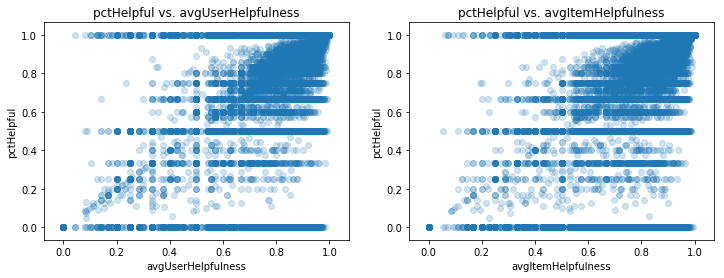

In [46]:
f, ax = plt.subplots(1,2)

ttl = 'pctHelpful vs. avgUserHelpfulness'
xData = train.loc[:,'avgUserHelpfulness'].values
ax[0].scatter(xData, train.pctHelpful, alpha=0.2)
ax[0].set_title(ttl)
ax[0].set_xlabel('avgUserHelpfulness')
ax[0].set_ylabel('pctHelpful')

ttl = 'pctHelpful vs. avgItemHelpfulness'
xData = train.loc[:,'avgItemHelpfulness'].values
ax[1].scatter(xData, train.pctHelpful, alpha=0.2)
ax[1].set_title(ttl)
ax[1].set_xlabel('avgItemHelpfulness')
ax[1].set_ylabel('pctHelpful')

f.set_figheight(4)
f.set_figwidth(12)
plt.show();

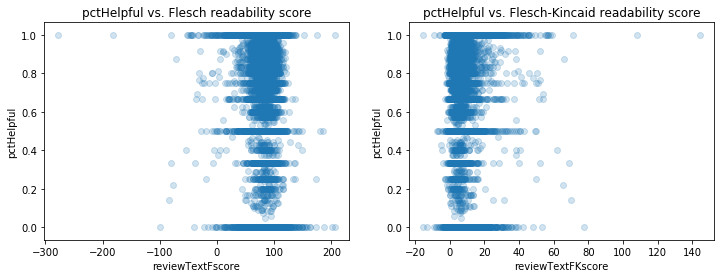

In [50]:
f, ax = plt.subplots(1,2)

ttl = 'pctHelpful vs. Flesch readability score'
xData = train.loc[:,'reviewTextFscore'].values
ax[0].scatter(xData, train.pctHelpful, alpha=0.2)
ax[0].set_title(ttl)
ax[0].set_xlabel('reviewTextFscore')
ax[0].set_ylabel('pctHelpful')

ttl = 'pctHelpful vs. Flesch-Kincaid readability score'
xData = train.loc[:,'reviewTextFKscore'].values
ax[1].scatter(xData, train.pctHelpful, alpha=0.2)
ax[1].set_title(ttl)
ax[1].set_xlabel('reviewTextFKscore')
ax[1].set_ylabel('pctHelpful')

f.set_figheight(4)
f.set_figwidth(12)
plt.show();

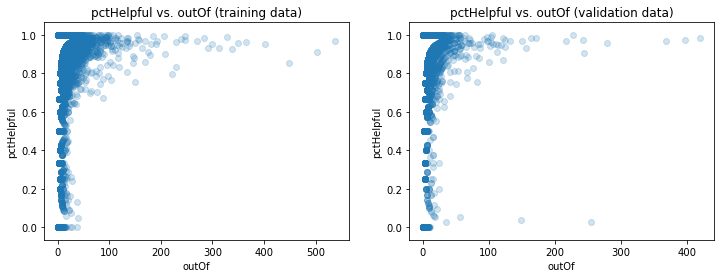

In [53]:
f, ax = plt.subplots(1,2)

ttl = 'pctHelpful vs. outOf (training data)'
xData = train.loc[:,'outOf'].values
ax[0].scatter(xData, train.pctHelpful, alpha=0.2)
ax[0].set_title(ttl)
ax[0].set_xlabel('outOf')
ax[0].set_ylabel('pctHelpful')

ttl = 'pctHelpful vs. outOf (validation data)'
xData = val.loc[:,'outOf'].values
ax[1].scatter(xData, val.pctHelpful, alpha=0.2)
ax[1].set_title(ttl)
ax[1].set_xlabel('outOf')
ax[1].set_ylabel('pctHelpful')

f.set_figheight(4)
f.set_figwidth(12)
plt.show();

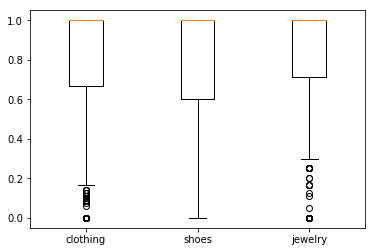

In [17]:
# plot boxplot of pctHelpful by shoes vs clothing categories
data = [train.loc[train.category_Clothing == 1,'pctHelpful'],
       train.loc[train.category_Shoes == 1,'pctHelpful'],
       train.loc[train.category_Jewelry == 1,'pctHelpful']]

plt.boxplot(data)
labs = ['clothing','shoes','jewelry']
plt.xticks([1,2,3],labs)
plt.show();

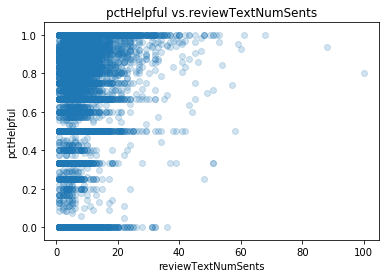

In [20]:
plotVsPctHelpful('reviewTextNumSents')

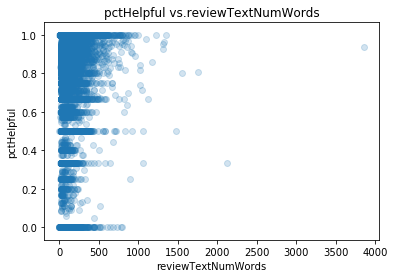

In [21]:
plotVsPctHelpful('reviewTextNumWords')

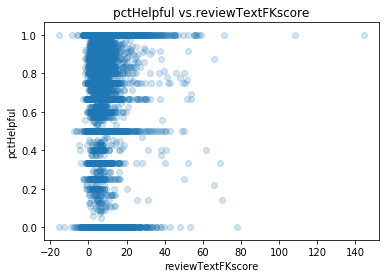

In [22]:
plotVsPctHelpful('reviewTextFKscore')

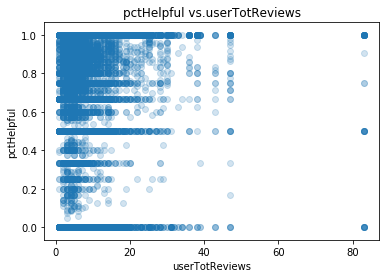

In [32]:
plotVsPctHelpful('userTotReviews')

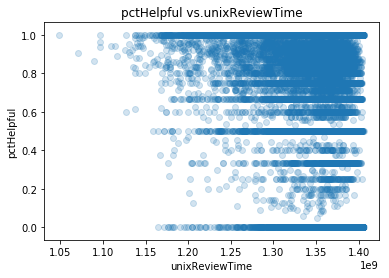

In [24]:
plotVsPctHelpful('unixReviewTime')

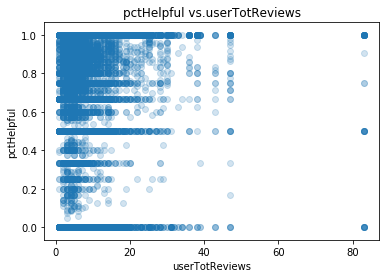

In [25]:
plotVsPctHelpful('userTotReviews')

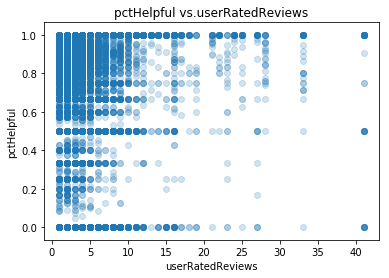

In [26]:
plotVsPctHelpful('userRatedReviews')

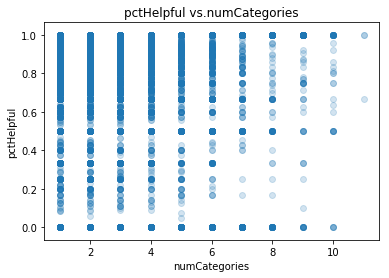

In [27]:
plotVsPctHelpful('numCategories')

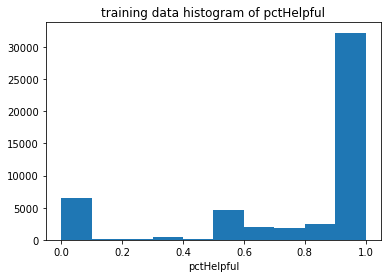

In [28]:
plt.hist(train.pctHelpful)
plt.title('training data histogram of pctHelpful')
plt.xlabel('pctHelpful')
plt.show();

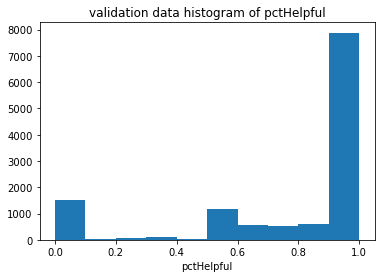

In [29]:
plt.hist(val.pctHelpful)
plt.title('validation data histogram of pctHelpful')
plt.xlabel('pctHelpful')
plt.show();

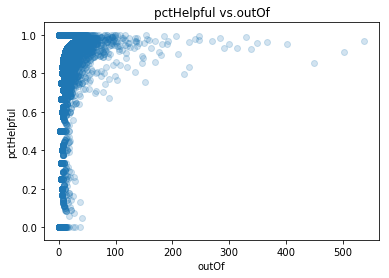

In [30]:
plotVsPctHelpful('outOf')

In [31]:
thresh = 23
train_1 = train.loc[train['outOf']<thresh,:]
train_2 = train.loc[train['outOf']>=thresh,:]

val_1 = val.loc[val['outOf']<thresh,:]
val_2 = val.loc[val['outOf']>=thresh,:]

In [ ]:
plt.subplot(1, 2, 1)
plt.scatter(train_1.outOf, train_1.pctHelpful, alpha=0.25)
plt.xlabel('outOf')
plt.ylabel('pctHelpful')

plt.subplot(1, 2, 2)
plt.scatter(train_2.outOf, train_2.pctHelpful, alpha=0.25)
plt.xlabel('outOf')
plt.suptitle('pctHelpful vs. outOf')

plt.show();

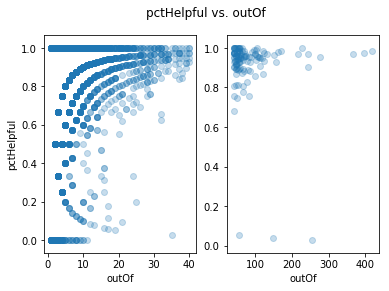

In [51]:
plt.subplot(1, 2, 1)
plt.scatter(val_1.outOf, val_1.pctHelpful, alpha=0.25)
plt.xlabel('outOf')
plt.ylabel('pctHelpful')

plt.subplot(1, 2, 2)
plt.scatter(val_2.outOf, val_2.pctHelpful, alpha=0.25)
plt.xlabel('outOf')
plt.suptitle('pctHelpful vs. outOf')

plt.show();

In [ ]:
tr_r1 = train.loc[train['rating']==1,:]
tr_r2 = train.loc[train['rating']==2,:]
tr_r3 = train.loc[train['rating']==3,:]
tr_r4 = train.loc[train['rating']==4,:]
tr_r5 = train.loc[train['rating']==5,:]

In [ ]:
plt.scatter(tr_r1.outOf,tr_r1.pctHelpful,alpha=0.25);

In [ ]:
plt.scatter(tr_r2.outOf,tr_r2.pctHelpful,alpha=0.25);

In [ ]:
plt.scatter(tr_r3.outOf,tr_r3.pctHelpful,alpha=0.25);

In [ ]:
plt.scatter(tr_r4.outOf,tr_r4.pctHelpful,alpha=0.25);

In [ ]:
plt.scatter(tr_r5.outOf,tr_r5.pctHelpful,alpha=0.25);